# Automatic PKIKP Onset Phase Picker

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day5/D5_Lab.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April, 2025.

This notebook demonstrates an application of convolutional neural network in deep Earth seismology. Here the AI tool automatises the laborious data collection process previously performed by skillful analysts. The train CNN network is trained on synthetic waveforms to pick the onset of PKIKP waves, the compressional waves transversing the whole Earth diameter, including the Earth's inner core. We expect that the ever-expanded dataset havested by AI could help reveal new insights into the structures and dynamics of the Earth's inner core.

This notebook is adopted from the orignal [Github Repository](https://github.com/JiarunZhou/PKIKP_Onset_Picker.git) developed by PhD Scholar Jiarun Zhou (ANU) supplementing the following application:

* Zhou J., T.-S. Phạm, H. Tkalčić, Deep-learning phase-onset picker for deep Earth seismology: PKIKP waves, Journal of Geophysical Research: Solid Earth, 129 (9), [10.1029/2024JB029360](https://doi.org/10.1029/2024JB029360), 2024.

---
## What we do in this notebook

- Get familiarised with `tensorflow` deep learning framework
- Train a convolutional neural network on synthetic training datasets
- Test the trained picker on real waveforms using the sliding window strategy

### *IMPORTANT* Preparing the working environment

Deep learning model traininging might be computationally expensive. Using GPU significantly reduce the compute time. In Google Colab, you have free access to GPU and TPU devices. It is strongly recommended to train the model using a GPU device. Select `Runtime`, `Change runtime type`, pick your device.

After that, similar to other excercises, run the next cell to install Python packages in the working environments of the Colab session. Note that, the packages are removed from the evironment when this session is closed.

In [1]:
# set up colab environment - uncomment the next line if running in colab

!pip install obspy numpy==1.26.4

In [2]:
#@title Run to activate retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Training the convolutional neural network for PKIKP onset picker

#### Download training datasets

We download the training datasets consisting of synthetic waveforms and labels. The datasets include three subsets: regular (synthetic P waves), target (particular emergent P waves), and control set (real noise). The waveforms are sampled at 40 Hz and generated to 20-s long. Non-zero labels mark the PKIKP wave onset, while zero labels indicate noisy waveforms. The datasets were simulated to mimic main features of teleseismic PKIKP waves transversing the Earth's inner core. More details can be found in Zhou et al. (2024).

In [3]:
# download data from google drive using gdown
import gdown, zipfile
from pathlib import Path
## Download the Bedmap2 datasets in GeoTIFF format from Google Drive using gdown
url = "https://drive.google.com/uc?id=14VV1W1mK3gIAWX4J8FWXtUilrLZnMtmE"
if not Path('Data_pack.zip').exists():
    gdown.download(url, 'Data_pack.zip', quiet=False)
## Unzip the downloaded file
if not (Path('Train_data').exists() or Path('Test_data').exists()):
    with zipfile.ZipFile('Data_pack.zip', 'r') as f:
        f.extractall('.')

Downloading...
From (original): https://drive.google.com/uc?id=14VV1W1mK3gIAWX4J8FWXtUilrLZnMtmE
From (redirected): https://drive.google.com/uc?id=14VV1W1mK3gIAWX4J8FWXtUilrLZnMtmE&confirm=t&uuid=79b7fad2-ca44-4a40-90c5-fcd2d2fc88f0
To: /content/Data_pack.zip
100%|██████████| 890M/890M [00:12<00:00, 74.0MB/s]


The three files downloaded are 301M:
    
    301M	Noise.hdf5
    301M	RegularP.hdf5
    301M	TargetP.hdf5

Each contains 100,000 waveforms of 20 seconds long sampled at 40 samples per second.

Next, the datasets are loaded into memory as `np.array`.

In [4]:
from pathlib import Path
import h5py
import numpy as np

## basic parameters
sampling_rate = 40
waveform_len = 20

def load_train_data(loading_num):
    ## Load waveforms and onset labels.
    waveforms = [] # waveforms
    labels = [] # onset labels
    names = [] # sub dataset names
    for file in Path('Train_data').glob('*.hdf5'):
        with h5py.File(file, "r") as f: # open hdf5 and read content
            data = np.array(f["data"])[:loading_num]
            t0 = np.array(f["t0"])[:loading_num]
        waveforms.append(data)
        labels.append(t0)
        names.append(file.name.split('.')[0])
    print ('Datasets:', names)
    print ("Total number of samples: %d"%sum([len(_) for _ in waveforms]))
    return waveforms, labels, names

waveforms, labels, names = load_train_data(loading_num=10000)

Datasets: ['TargetP', 'RegularP', 'Noise']
Total number of samples: 30000


The total available number of samples, i.e., pairs of waveform and onset label, are 295,275. However to reduce the actual training runtime for demonstration purposes, only 30,000 samples are loaded.

30 samples randomly are picked from the datasets for visual inspection.

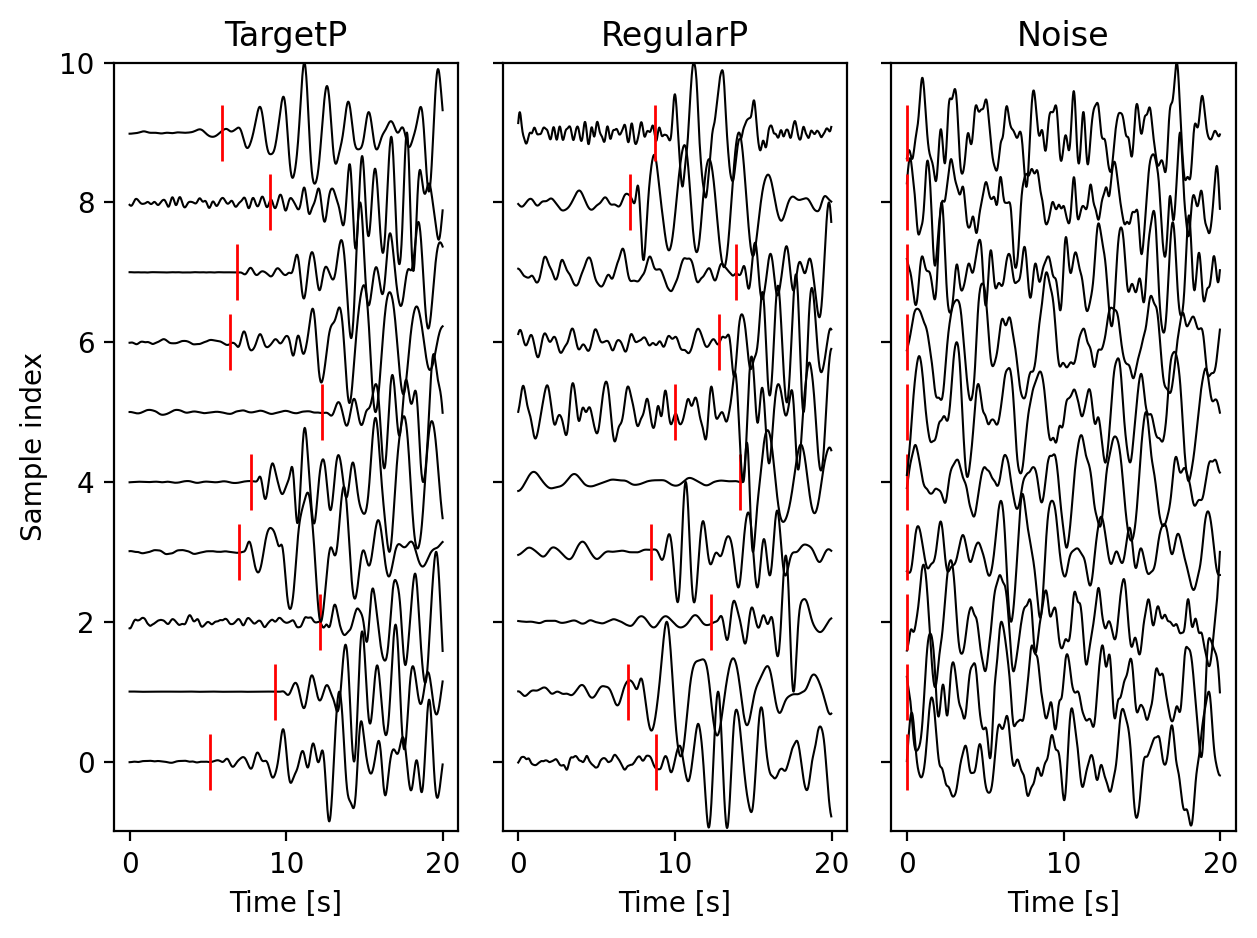

In [6]:
import matplotlib.pyplot as plt
tvec = np.arange(sampling_rate*waveform_len) / sampling_rate
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
for i in range(3):
    tmp = np.random.randint(0, len(waveforms[i]), 10) # pick 10 random waveforms from the i-th subset
    for j in range(len(tmp)):
        # plot waveforms
        ax[i].plot(tvec, waveforms[i][tmp[j]] + j, c='k', lw=0.75)
        # plot labels
        ax[i].plot(labels[i][tmp[j]], j, '|r', ms=20, lw=1.5)
    ax[i].set(xlabel='Time [s]', title=names[i])
ax[0].set(ylabel='Sample index', ylim=(-1, 10))
fig.tight_layout()
plt.show()

### Model
Now, we build a neural network, whose architecture is visualized below, using tensorflow keras modules. The CNN model comprises of four 1D convolutional layers, followed by max pooling layers to downsize by half. The output of the convolutional layer is then flattened and fed into two fully connected layer, and finally outputed with linear operator.

<div>
<center>
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/952cff41-9b65-4343-8cd8-678090e9f543/jgrb56919-fig-0004-m.jpg" width="300"/>
</div>
(Source: https://doi.org/10.1029/2024JB029360)

In [7]:
## import necessary tensorflow keras modules
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import Huber, Reduction
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_CNN_picker(npts, normalize = True, lr = 0.001):
    ## define convolutional neural layers
    n_filters = [32, 64, 128, 256]
    s_kernels = [7, 5, 4, 3]
    inputs = Input(shape=(npts,1))
    x = inputs
    for n_filter, s_kernel in zip(n_filters, s_kernels):
        x = Conv1D(filters = n_filter, kernel_size = s_kernel, padding = 'same', activation = "relu")(x)
        x = MaxPooling1D()(x)
        if normalize:
            x = BatchNormalization()(x)

    ## flatten the output of the convolutional layers
    x = Flatten()(x)

    ## define fully connected, i.e., dense, layers
    for _ in range(2):
        x = Dense(200, activation = 'relu')(x)
        if normalize:
            x = BatchNormalization()(x)

    ## output of the dense layer
    outputs = Dense(1, activation = "linear")(x)

    ## define the CNN model and specify loss function and optimizer
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss=Huber(reduction = Reduction.SUM_OVER_BATCH_SIZE),
                  optimizer=Adam(learning_rate = lr))

    return model

## call the definition function to instatitate the CNN model
model_raw = create_CNN_picker(npts = waveform_len*sampling_rate)

## print model sumary
model_raw.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 800, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 400, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     2,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,746,137 (10.48 MB)

 Trainable params: 2,744,377 (10.47 MB)

 Non-trainable params: 1,760 (6.88 KB)

The expected summary model output reads
```
 Total params: 2,746,137 (10.48 MB)
 Trainable params: 2,744,377 (10.47 MB)
 Non-trainable params: 1,760 (6.88 KB)
```
The number of trainable params, 2,744,377, is the number of parameter that is to be estimated to minimize the `Huber` loss function between waveforms and labels. The loss funciton is minimized using the `Adam` optimizer. The optimization algorithm interatively finds a lower loss value when decending along the direction opposite to the loss function's gradient, i.e., gradient decent.

Train the model and plot the curves of loss during the training process. An early stopping method that allows training stops early if the validation loss has no longer decreased over 5 epochs is used.

In [8]:
from time import time
from obspy.core import UTCDateTime

def trainer(x, y, model,
            epochs = 20,
            validation_split = 0.2,
            batch_size = 32,
            early_stop = True,
            verbose_training = 1,
            shuffle = True,
            plot_hist = True, save_plot = "Loss_curve.jpg"):

    callbacks = []
    if early_stop == True:
        callbacks.append(
        EarlyStopping(monitor = 'val_loss',
                    start_from_epoch = 10,
                    patience = 5,
                    restore_best_weights = True,
                    verbose = 1)
        )

    start_training_time = time()
    hist = model.fit(x, y,
                    epochs = epochs,
                    validation_split = validation_split,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    callbacks = callbacks,
                    verbose = verbose_training)
    performance_time = time() - start_training_time

    print("Training starts at",UTCDateTime(start_training_time),"; run in:", performance_time)
    if plot_hist == True: plot_hist_curve(hist, save_plot)

    return hist

def plot_hist_curve(hist, save_plot):
    train_loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    plt.figure()
    plt.plot(range(len(train_loss)),train_loss, label = "Training_loss")
    plt.plot(range(len(val_loss)),val_loss, label = "Validation_loss")
    plt.xlabel("Epoch")
    plt.legend()
    if save_plot != False:
        plt.savefig(save_plot, dpi = 300)
    plt.show()

Three sets are split:

- Training: The model learns from it;
- Validation: The model evaluates the loss on it after each epoch, and then updates weights itself by back propagation;
- Test: The trained model evaluates its final loss&accuracy.

An early stopping method that allows training stops early if the validation loss has no longer decreased over 5 epochs is used. A warm-up period of 10 epochs is set for early stopping.

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 2.7388 - val_loss: 0.3428
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.5532 - val_loss: 0.2340
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5001 - val_loss: 0.2027
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4984 - val_loss: 0.1639
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4996 - val_loss: 0.1727
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.4926 - val_loss: 0.3494
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4468 - val_loss: 0.1615
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4662 - val_loss: 0.1302
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4970 - val_loss: 0.1922
Epoch 10/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.4452 - val_loss: 0.1433
Epoch 11/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.3865 - val_loss: 0.1322
Epoch 12/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6

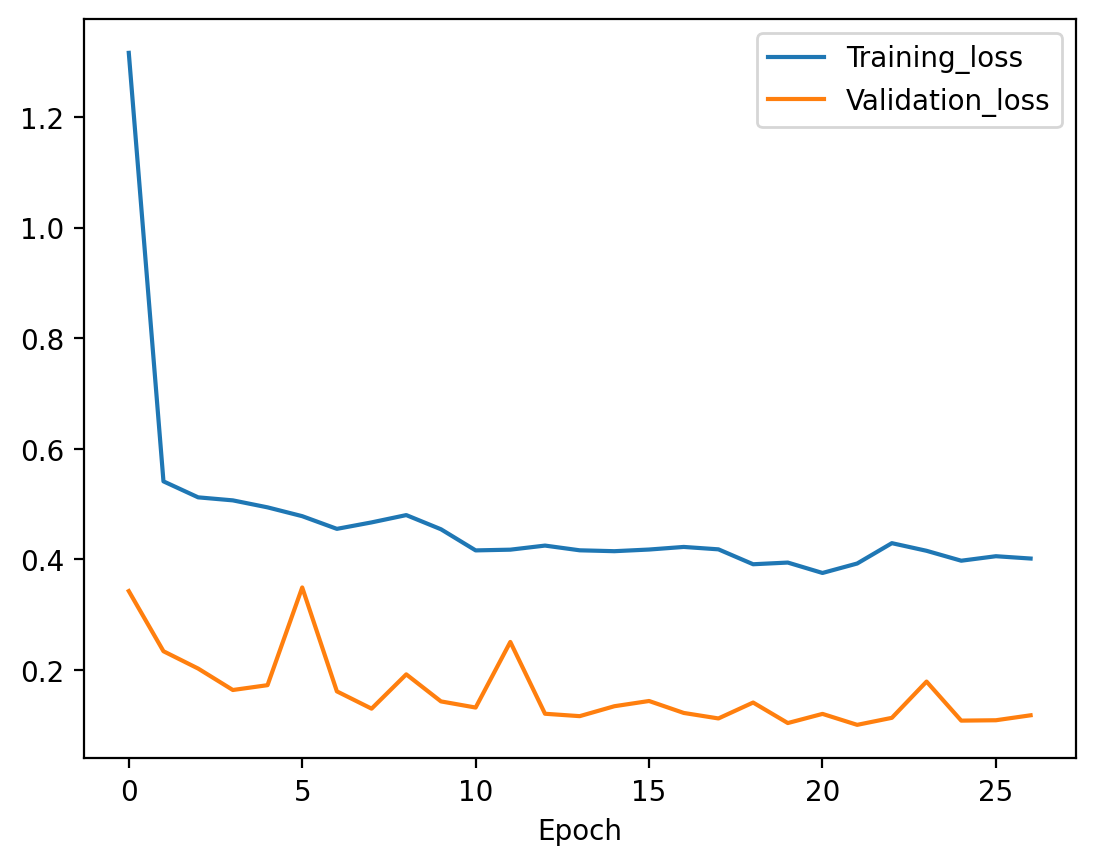

In [9]:
from sklearn.model_selection import train_test_split

## Stack three training sets
x = np.vstack(waveforms)
y = np.vstack(labels)

## data is shuffled before splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, shuffle = True, random_state = 101)

## Train
hist = trainer(x_train, y_train,
        model_raw,
        epochs = 30,
        validation_split = 0.2,
        batch_size = 32,
        early_stop = True,
        verbose_training = 1,
        shuffle = True, # Shuffle the training data before each epoch
        plot_hist = True, save_plot = "Loss_curve.jpg")

The training process should take about 3 minutes when running with a T4 GPU device. The output figure shows the training and validation loss. The training loss (blue line) is minimized during the training process. Trained model can be used to predict the outputs corresponding to the test set, `x_test`, which has not been seen by the optimizer.

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


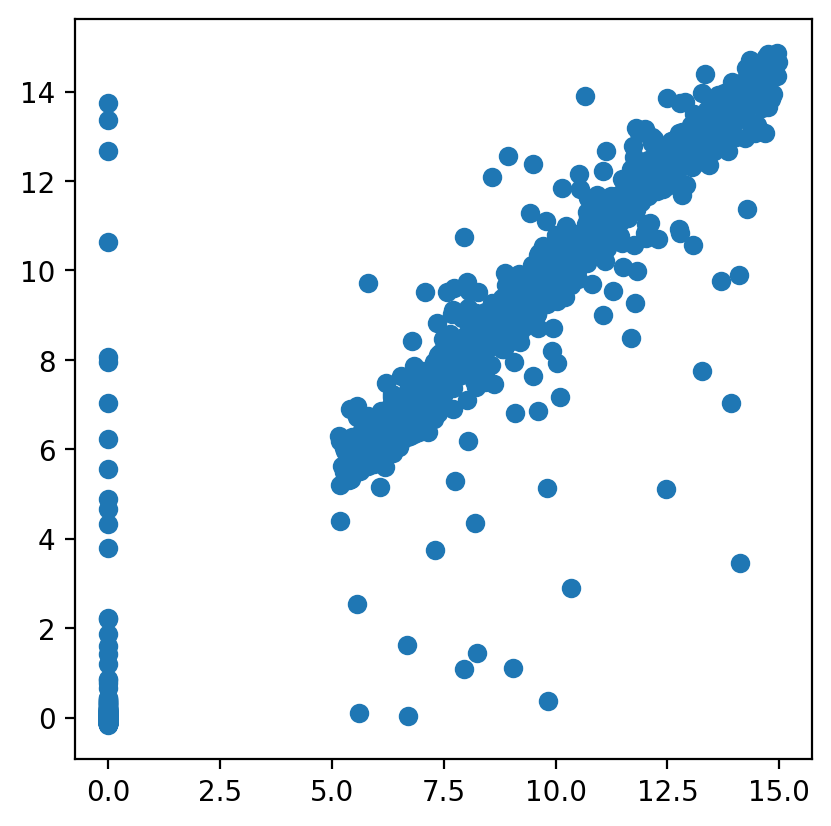

In [10]:
y_out = model_raw.predict(x_test)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(y_test, y_out)
plt.show()

---
## Testing the algorithm with real data

In [11]:
#@title Supporting functions
#@markdown **Note**: The following functions are used to process the data and perform the picking. You can skip this section if you are only interested in the model training.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN


def pre_process(data, sampling_rate = 40, len_input = 50,
                freq_min = 0.5, freq_max= 2, prediction = 60, detrend = True):

    # Pre-process
    data.resample(sampling_rate)
    if detrend == True: data.detrend(type="linear")
    data.filter(type="bandpass", freqmin=freq_min, freqmax=freq_max)

    #Cut
    st = []
    window_start = int(prediction-len_input*0.5)
    if window_start < 0:
        raise ValueError("The input waveform is too short (Default: 150 s) or the cut window is too long (Default: 50 s).")
    for tr in data:
        tr = tr[window_start*sampling_rate:(window_start+len_input)*sampling_rate]
        tr = tr/np.max(abs(tr))
        st.append(tr)

    return np.array(st)


def sliding_window_picking(tr, model, sampling_rate = 40, len_window = 20, t_shift = 0.1, only_valid = True):
    n_shift = t_shift * sampling_rate
    n_length = len_window*sampling_rate

    tt = (np.arange(0, len(tr), n_shift)) /sampling_rate # start of each window

    shape = [int(np.floor(len(tr)/n_shift - n_length/n_shift + 1)),n_length]
    strides = [int(tr.strides[0]*n_shift),tr.strides[0]]
    tr_win = np.lib.stride_tricks.as_strided(tr, shape=shape, strides=strides)

    tr_win = normalize(tr_win,norm = "max")
    tt = tt[:len(tr_win)]
    tr_win = np.reshape(tr_win,(len(tr_win),len_window*sampling_rate,1))
    ts = model.predict(tr_win, verbose = False, batch_size=32) # pick in each window

    if only_valid == True:
        # Only keep the picks in range of picking windows
        ts_valid = []
        for j in range(len(ts)):
            if np.abs(ts[j]) <= len_window and np.abs(ts[j]) >= 0:
                ts_valid.append(ts[j]+tt[j])
            else:
                ts_valid.append([0]) # Out-of-range picks will be reset to the end
        return tt, ts_valid
    else:
        return tt,ts


def cluster_preds(predictions, eps=0.1, min_neighbors=5):
    dbscan = DBSCAN(eps, min_samples=min_neighbors) ## Perform DBSCAN cluster
    dbscan.fit(predictions.reshape(-1,1))
    clusters, counts = np.unique(dbscan.labels_, return_counts=True)
    dbscan_labels = dbscan.labels_
    if -1 in clusters:
        clusters = clusters[1:]
        counts = counts[1:]
    picks = np.zeros(len(clusters))
    for c in clusters:
        picks[c] = np.mean(predictions[dbscan.labels_ == c])

    if len(picks) == 0:
        picks == np.zeros(1)
        counts == np.zeros(1)

    return picks, dbscan_labels, counts


def picker(data, model, sampling_rate = 40, t_shift = 0.1, eps = 0.1, return_optimal = True):
    len_window = 20 # model input length = sliding window length

    picks_highest_quality = []
    qualities_highest = []
    picks_all = []
    qualities_all = []

    if type(model) == str:
        model = load_model(model)

    for tr in data:
        # Predict
        tt, ts_valid = sliding_window_picking(tr, model,
                                              sampling_rate, len_window, t_shift, only_valid = True)

        # Cluster picks
        picks,dbscan_labels,counts = cluster_preds(np.array(ts_valid), eps=eps, min_neighbors=5)
        if len(picks) == 0:
            raise ValueError("No auto pick is returned.")

        # Quality of picks
        qualities = counts/(len_window/t_shift)

        picks_highest_quality.append(picks[np.argmax(qualities)])
        qualities_highest.append(np.max(qualities))
        picks_all.append(picks)
        qualities_all.append(qualities)

    if return_optimal == True:
        return picks_highest_quality, qualities_highest
    else:
        return picks_all, qualities_all


def auto_pick_plot(tr, model, save_name = "Plot.jpg"):

    auto_picks, qualities = picker(tr, model, return_optimal = False)
    optimal_pick = auto_picks[0][np.argmax(qualities)]

    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(2, 1,height_ratios=(3, 2),hspace=0.1)
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(tr[0],c = "k",lw = 1.2)
    ax0.axvline(optimal_pick*40,c= "g",lw = 1.5,label = "Automatic pick: %.2f s"%optimal_pick)
    # ax0.axvline(onset_in_window*40,c = "r",lw = 1.5,label = "Manual pick: %.2f s"%onset_in_window)
    ax0.set_xticks(ticks = np.arange(0,2001,200), labels = [])
    ax0.set_yticks([-1,0,1])
    ax0.set_yticklabels([-1,0,1],fontsize = 14)
    ax0.set_ylabel("Amplitude",fontsize = 15)
    ax0.set(xlim=(0,2000))
    ax0.legend(fontsize = 13,loc = "upper left")

    ax1 = fig.add_subplot(gs[1])
    ax1.axvline(optimal_pick*40,c= "g",lw = 1.5,ls = "dotted")
    for ia,a in enumerate(auto_picks[0]):
        l1 = ax1.axvline(a*40,ymin = 0,ymax = qualities[0][ia],color = "green",lw  = 1.5)
    ax1.grid(True, axis = "both",linestyle = "--")
    ax1.set_xticks(np.arange(0,2001,200))
    ax1.set_xticklabels(np.arange(-25,26,5),fontsize = 14)
    ax1.set_xlabel("Time w.r.t. ak135 prediction (s)",fontsize = 15)
    ax1.set_ylabel("Quality",fontsize = 15)
    ax1.legend([l1],["Sliding-window \npicks"],fontsize = 13,loc = "upper right")
    plt.savefig(save_name,dpi=300,bbox_inches = "tight")


def picking_animation(tr, model, len_input = 50, sampling_rate = 40, t_shift = 0.1, save_name = "Animation.mp4"):
    from matplotlib.animation import FuncAnimation,FFMpegWriter

    len_window = 20

    ## Get instantaneous picks
    tt, ts = sliding_window_picking(tr[0], model, only_valid = False)
    ts = [ts[j] + tt[j] for j in range(len(ts))]
    picks,dbscan_labels,counts = cluster_preds(np.array(ts))

    ## plot
    fig,ax = plt.subplots(2,figsize = (10,8),sharex = True)
    ax[0].set_ylim(-1.05,1.05)
    ax[0].plot(np.arange(0,len_input,1/sampling_rate),tr[0])
    # ax[0].axvline(onset_in_window, c= "r",lw = 2, ls = "--", label = "Human picked arrival")
    ln1, = ax[0].plot([],[], c= "g",lw = 2, label = "Instantaneous CNN pick")
    ln2, = ax[0].plot([], [], 'tab:grey',label = "Sliding window")
    ln3, = ax[0].plot([], [], 'tab:grey')
    ax[0].legend(loc = "upper right")
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel("Time (s)",fontsize = 15)
    ax[1].set_ylabel("Quality",fontsize = 15)
    ax[1].set_xticks(np.arange(0,51,5))
    ln4, = ax[1].plot([],[],"go",ms=1.5)
    collection = ax[0].fill_between([0,len_window],-1.05,1.05,facecolor = "lightgrey",alpha = 0.5)
    xdata3,ydata3 = [],[]
    def update(frame):
        xdata = ts[frame]
        ydata = np.linspace(-1.05,1.05,100)
        xdata2 = tt[frame]
        xdata3.append(picks[dbscan_labels[frame]])
        dbscan_label_f = len([d for d in dbscan_labels[0:frame+1] if d == dbscan_labels[frame]])

        if picks[dbscan_labels[frame]] != 0 and dbscan_labels[frame] != -1:
            try:
                len_ydata3 = dbscan_label_f/(len_window/t_shift)
            except ZeroDivisionError:
                len_ydata3 = 0
        else:
            len_ydata3 = 0
        ydata3.append(len_ydata3)

        dummy = ax[0].fill_between([xdata2,xdata2+len_window], -1.05, 1.05, alpha=0)
        dp = dummy.get_paths()[0]
        dummy.remove()
        #update the vertices of the PolyCollection
        collection.set_paths([dp.vertices])

        ln1.set_data(xdata,ydata)
        ln2.set_data([xdata2],ydata)
        ln3.set_data([xdata2+len_window],ydata)
        ln4.set_data(xdata3,ydata3)

        return ln1,ln2,ln3,ln4

    ani = FuncAnimation(fig, func = update, frames=len(ts), blit=True, repeat = False)
    writer = FFMpegWriter(fps = 15)
    ani.save(save_name,writer = writer,dpi = 300)

Here we load the trained model.

Read an observed real PKIKP waveform example. Here, the waveform has 150-s length. The predicted PKIKP onset by ak135 model (Kennett et al., 1995) is located at the 60th second. Hand-picked PKIKP absolute travel time is provided in its information.

In [12]:
from obspy import read, Stream

tr = read("Test_data/PKP_NE22.YP.BHZ.SAC")
PKIKP_travel_time = tr[0].stats.sac.t2
waveform_start = tr[0].stats.sac.b
onset = PKIKP_travel_time - waveform_start
prediction = 60

print("Wavefrom shape:",np.shape(tr))
print("PKIKP onset: ak135 prediction: %.2f s; Hand picking: %.2f s"%(prediction,onset))

Wavefrom shape: (1, 6001)
PKIKP onset: ak135 prediction: 60.00 s; Hand picking: 56.90 s


Pre-process the waveform. A default 50-s length waveform segment around the ak135 prediction is cut as the input of the automatic picker.

In [13]:
sampling_rate = 40
len_input = 50
freq_filter = [0.5,2]
tr_cut = pre_process(tr, sampling_rate, len_input, freq_filter[0], freq_filter[1])

Pick the PKIKP onset on the processed waveform by calling the Picker function. A 20-s length window is shifting along the input waveform, and the network model returns an instantaneous pick for each step. The pick with the highest quality is chosen as the optimal one.

In [14]:
auto_pick, quality = picker(tr_cut, model_raw, sampling_rate, return_optimal = True)

print("Auto picked PKIKP onset: %.2f s picking quality: %.2f"%(auto_pick[0], quality[0]))
onset_in_window = onset - prediction + len_input / 2
print("Manual pick on the waveform: %.2f s"%onset_in_window)

Auto picked PKIKP onset: 21.47 s picking quality: 0.48
Manual pick on the waveform: 21.90 s


### Result plotting

We can acquire all picks with quality and get a quality plot.

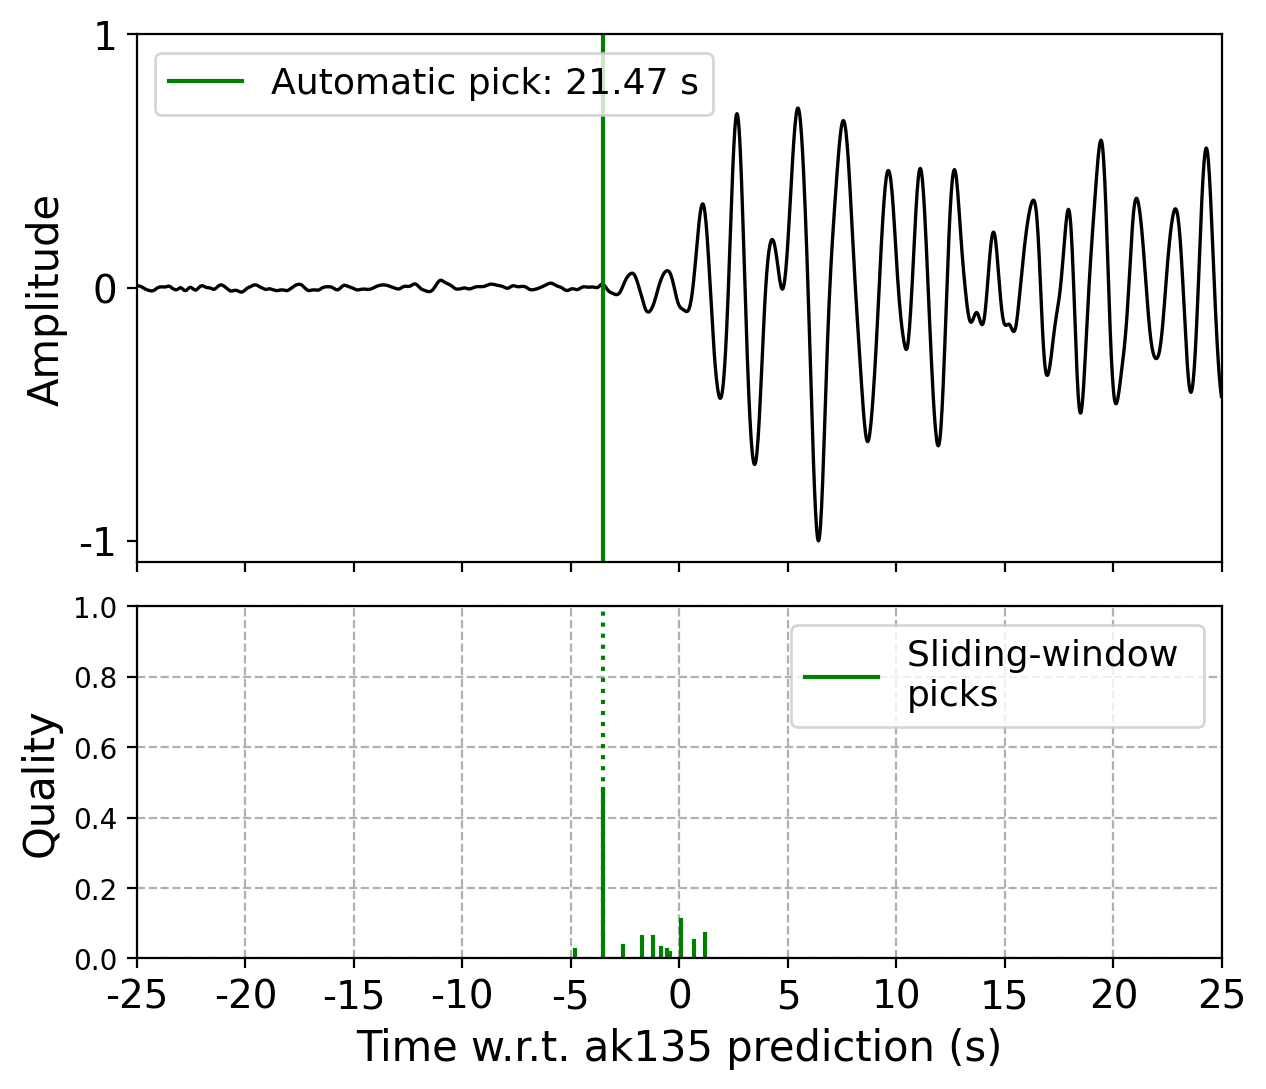

In [15]:
auto_pick_plot(tr_cut, model_raw, "PKP_NE22.YP.BHZ.SAC.jpg")

An animation displaying the dynamic picking process is saved.

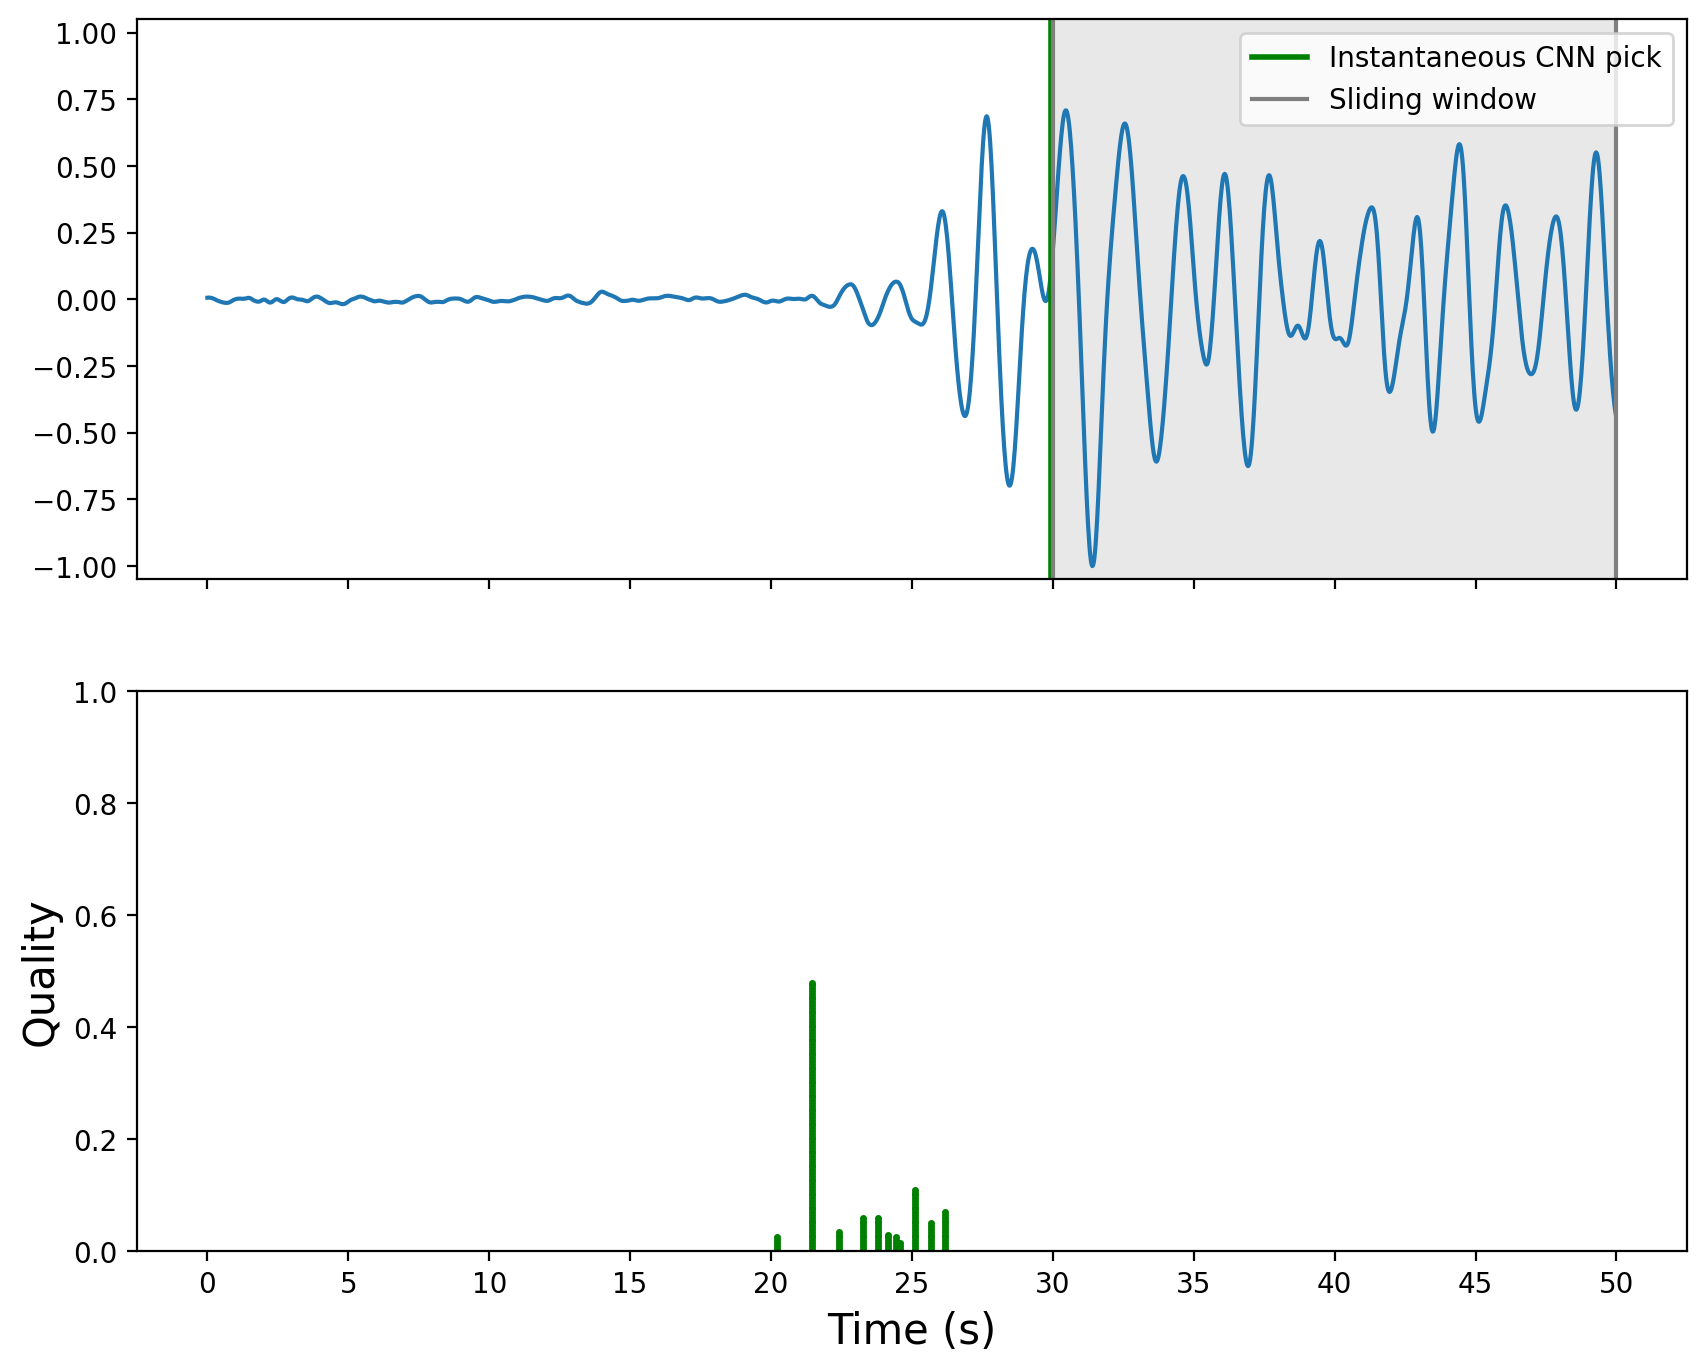

In [16]:
picking_animation(tr_cut, model_raw, save_name="Animation.mp4")

---
## Challenge

Would you mind to try the trained network on more real waveform data? Copy the code below to and replace `<CHANGE ME>` with necessary code for for reald processing. You can start with the code here:

    Code example

In [ ]:
## Enter your code here

In [ ]:
#@title Click here for solution

# Load training data
waveforms_2, labels_2, names_2 = load_train_data(loading_num=15000)

# Create a new raw model, which should have the exact architecture as the first one
model_2 = model_raw = create_CNN_picker(npts = waveform_len*sampling_rate)

# Split data for training
## Stack three training sets
x_2 = np.vstack(waveforms_2)
y_2 = np.vstack(labels_2)

## data is shuffled before splitting
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size = 0.1, shuffle = True, random_state = 101)

## Train
hist_2 = trainer(x_train_2, y_train_2,
        model_2,
        epochs = 30,
        validation_split = 0.2,
        batch_size = 32,
        early_stop = True,
        verbose_training = 1,
        shuffle = True, # Shuffle the training data before each epoch
        plot_hist = False)

## Predict on test data
model_2.predict(x_test_2)

y_out_2 = model_raw.predict(x_test_2)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(y_test_2, y_out_2)
plt.show()